# "Variational inference with TensorFlow-Probability"
> "An overview of the variational inference APIs available in TensorFlow-Probability."

- toc: false
- branch: master
- badges: true
- comments: true
- author: Yves Barmaz
- categories: [bayesian modeling, variational inference, tensorflow-probability]

If you plan to automate the execution of multible Bayesian inference jobs, typically to regularly update your posterior distribution as new data comes in, you might find that MCMC algorithms take too long to sample their chains. Variational inference can speed things up considerably (you can find a good introduction [here](https://arxiv.org/abs/1601.00670)), at the expense of converging only to an approximation of the true posterior, which is often good enough for practical applications.

Lately, I have been experimenting with TensorFlow-Probability variational inference tools, namely [`tfp.vi.fit_surrogate_posterior`](https://www.tensorflow.org/probability/api_docs/python/tfp/vi/fit_surrogate_posterior) and [`tfp.layers`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational), to see how to integrate them into some of my projects.

I collected insights from various guides, tutorials, and code documentation, that I am summarizing here, mainly for future reference, but also for the benefit of people I will manage to convert to Bayesianism. The code is applied to a toy example of Bayesian logistic regression on simulated data, because it is helpful in this context to compare results to the true parameters of the data generating process.

In [1]:
#hide
# Uncomment and run this cell if you are using colab to install the required dependencies.
#!pip install tensorflow_probability
#!pip install arviz

In [2]:
#hide
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import arviz as az

In [3]:
#hide_output
true_params = np.array([1., 0., -2.])
true_offset = 1.

true_generating_process = tfd.JointDistributionSequentialAutoBatched([
    # features
    tfd.Sample(tfd.Normal(loc=0., scale=1.), true_params.shape[0]),
    # observations
    lambda features: tfd.Bernoulli(logits=true_offset +
                                   tf.tensordot(features, tf.convert_to_tensor(true_params, dtype=tf.float32), axes=1))
])

[X, y] = true_generating_process.sample(500)

## MCMC
It is always good to start with a benchmark, so I collected an MCMC sample of the posterior distribution and computed the means and standard deviations of the model parameters.

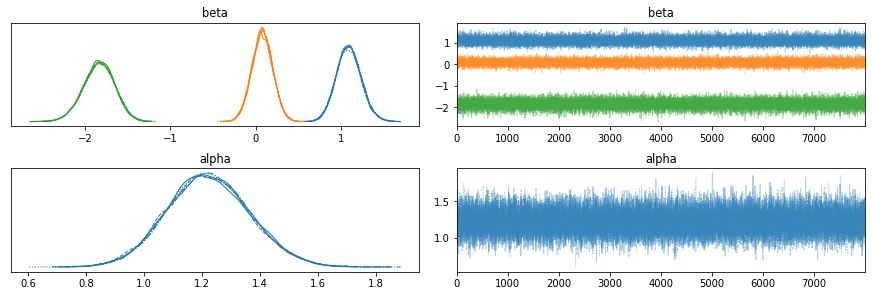

In [4]:
#hide_output
# Specify the model for Bayesian logistic regression.
mdl_logreg = tfd.JointDistributionSequentialAutoBatched([
    #betas
    tfd.Sample(tfd.Normal(loc=0., scale=5.), X.shape[1]),
    #alpha
    tfd.Normal(loc=0., scale=20.),
    #observations
    lambda alpha, betas: tfd.Independent(tfd.Bernoulli(logits=alpha + tf.tensordot(X, betas, axes=1)), reinterpreted_batch_ndims=1)
])

# Specify the MCMC algorithm.
dtype = tf.dtypes.float32
nchain = 5
b0, a0, _ = mdl_logreg.sample(nchain)
init_state = [b0, a0]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1]]
target_log_prob_fn = lambda *init_state: mdl_logreg.log_prob(
    list(init_state) + [y])

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
]

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=8000, burnin=1000):

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
               )
  
    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn,
        step_size=step_size),
      bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
      inner_kernel=kernel,
      num_adaptation_steps=burnin,
      step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
          inner_results=pkr.inner_results._replace(step_size=new_step_size)),
      step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
      log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )

    chain_state, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc,
        trace_fn=trace_fn)
    return chain_state, sampler_stat

# Run the chain
samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['beta', 'alpha']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

az.plot_trace(az_trace)
plt.show()

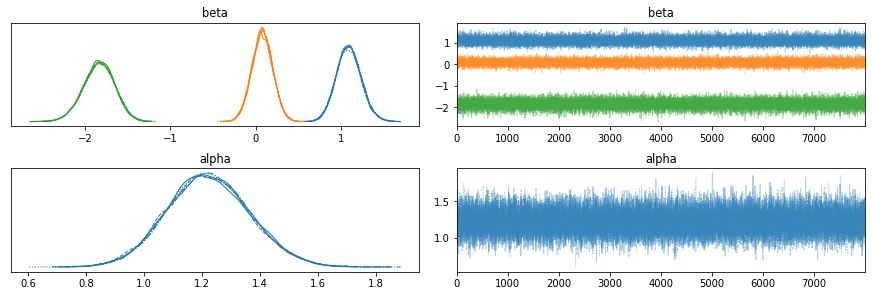

In [5]:
#hide_input
az.plot_trace(az_trace)
plt.show()

In [6]:
#hide_input
az.summary(az_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],1.095,0.145,0.823,1.368,0.001,0.001,34201.0,33151.0,34433.0,31987.0,1.0
beta[1],0.079,0.122,-0.147,0.312,0.000,0.001,74333.0,29295.0,74378.0,32250.0,1.0
beta[2],-1.840,0.184,-2.190,-1.501,0.001,0.001,23574.0,23363.0,23694.0,29070.0,1.0
alpha,1.223,0.142,0.957,1.492,0.001,0.001,35014.0,34357.0,35198.0,33159.0,1.0


In [7]:
#hide
def get_sample_stats(samples):
    betas = samples[0]
    alpha = samples[1]
    
    betas = tf.reshape(betas, [betas.shape[0]*betas.shape[1], betas.shape[2]])
    alpha = tf.reshape(alpha, [alpha.shape[0]*alpha.shape[1]])
    
    mu_betas = tf.reduce_mean(betas, axis=0)
    mu_alpha = tf.reduce_mean(alpha, axis=0)
    mus = tf.concat([mu_betas, tf.reshape(mu_alpha, [1])], axis=0)
    
    s_betas = tf.math.reduce_std(betas, axis=0)
    s_alpha = tf.math.reduce_std(alpha, axis=0)
    sigmas = tf.concat([s_betas, tf.reshape(s_alpha, [1])], axis=0)
    
    mcmc_mean = mus.numpy()
    mcmc_std = sigmas.numpy()
    
    return mcmc_mean, mcmc_std

mcmc_mean, mcmc_std = get_sample_stats(samples)

## Variational inference with tfp.vi
The dedicated tool for variational inference in TensorFlow-Probability, `tfp.vi.fit_surrogate_posterior`, requires a similar amount of preparatory work as `tfp.mcmc` algorithms. The specification of the target posterior is actually the same.

In [8]:
mdl_logreg = tfd.JointDistributionSequentialAutoBatched([
    #betas
    tfd.Sample(tfd.Normal(loc=0., scale=5.), X.shape[1]),
    #offset
    tfd.Normal(loc=0., scale=20.),
    #observations
    lambda offset, betas: tfd.Independent(tfd.Bernoulli(logits=offset + tf.tensordot(X, betas, axes=1)), reinterpreted_batch_ndims=1)
])

unnormalized_log_prob = lambda *x: mdl_logreg.log_prob(x + (y,))

Then, instead of specifying a Markov chain, we have to define a variational family of surrogate posterior candidates. This can require quite a bit of work, but if our model has been built with a joint distribution list and we are happy with a [mean field approximation](https://en.wikipedia.org/wiki/Variational_Bayesian_methods#Mean_field_approximation) (this is usually the case if we care only about the marginal posterior distributions of the individual model parameters and not their correlation), the TensorFlow tutorial on [modeling with joint distributions](https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution#variational_inference) provides a helper function to do that. Note that if the support of the distributions is not a full $\mathbb{R}^n$, we have to implement unconstraining bijectors. The same [tutorial](https://www.tensorflow.org/probability/examples/Modeling_with_JointDistribution#variational_inference) shows how to do it.

In [9]:
#hide_output
# Build meanfield ADVI for a jointdistribution
# Inspect the input jointdistribution and replace the list of distribution with
# a list of Normal distribution, each with the same shape.
def build_meanfield_advi(jd_list, observed_node=-1):
    """
    The inputted jointdistribution needs to be a batch version
    """
    # Sample to get a list of Tensors
    list_of_values = jd_list.sample(1)  # <== sample([]) might not work

    # Remove the observed node
    list_of_values.pop(observed_node)

    # Iterate the list of Tensor to a build a list of Normal distribution (i.e.,
    # the Variational posterior)
    distlist = []
    for i, value in enumerate(list_of_values):
        dtype = value.dtype
        rv_shape = value[0].shape
        loc = tf.Variable(
            tf.random.normal(rv_shape, dtype=dtype),
            name='meanfield_%s_mu' % i,
            dtype=dtype)
        scale = tfp.util.TransformedVariable(
            tf.fill(rv_shape, value=tf.constant(0.02, dtype)),
            tfb.Softplus(),
            name='meanfield_%s_scale' % i,
        )

        approx_node = tfd.Normal(loc=loc, scale=scale)
        if loc.shape == ():
            distlist.append(approx_node)
        else:
            distlist.append(
              # TODO: make the reinterpreted_batch_ndims more flexible (for 
              # minibatch etc)
              tfd.Independent(approx_node, reinterpreted_batch_ndims=1)
            )

    # pass list to JointDistribution to initiate the meanfield advi
    meanfield_advi = tfd.JointDistributionSequential(distlist)
    return meanfield_advi

It remains to choose an optimizer and set a few hyperparameters such as the number of optimization steps, the sample size used to estimate the loss function, and the learning rate of the optimizer. To better tune those and then to assess convergence, it can be helpful to enrich the trace function with statistics of the variational distribution.

In [10]:
#hide_output
meanfield_advi = build_meanfield_advi(mdl_logreg, observed_node=-1)

# Check the logp and logq
advi_samples = meanfield_advi.sample(4)
print([
  meanfield_advi.log_prob(advi_samples),
  unnormalized_log_prob(*advi_samples)
  ])

# Specify a trace function that collects statistics during inference and an optimizer
trace_fn = lambda x: (x.loss, meanfield_advi.mean(), meanfield_advi.stddev())
opt = tf.optimizers.Adam(learning_rate=.08)

#@tf.function(experimental_compile=True)
def run_approximation():
    loss_ = tfp.vi.fit_surrogate_posterior(
                unnormalized_log_prob,
                surrogate_posterior=meanfield_advi,
                optimizer=opt,
                sample_size=50,
                num_steps=200,
                trace_fn=trace_fn
    )
    return loss_

loss_, q_mean_, q_std_ = run_approximation()

[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([11.356   ,  9.718828, 11.382941,  9.115105], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-962.73627, -974.9345 , -962.9329 , -961.384  ], dtype=float32)>]


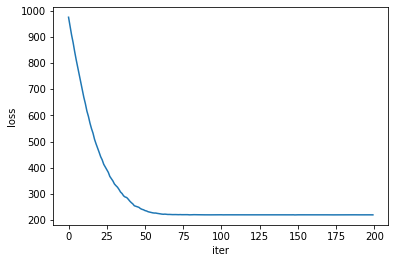

In [11]:
#hide_input
plt.plot(loss_)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

The loss itself is obviously a good indicator of convergence, but the model parameters seem to need a few more iterations to reach a steady state of the optimizer.

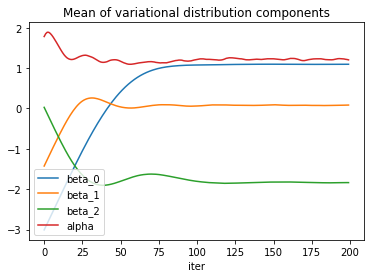

In [12]:
#hide_input
plt.plot(q_mean_[0].numpy())
plt.plot(q_mean_[1].numpy())
plt.xlabel('iter')
plt.legend(['beta_0', 'beta_1', 'beta_2', 'alpha'])
plt.title('Mean of variational distribution components')
plt.show()

The standard deviation estimates exhibit some more noise.

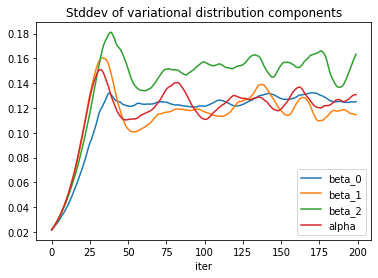

In [13]:
#hide_input
plt.plot(q_std_[0].numpy())
plt.plot(q_std_[1].numpy())
plt.xlabel('iter')
plt.legend(['beta_0', 'beta_1', 'beta_2', 'alpha'])
plt.title('Stddev of variational distribution components')
plt.show()

To reduce the noise, one can try to increase the sample size used to estimate the loss function, or decrease the learning rate. The price for both actions is a slower convergence, so the number of iterations would need to be adjusted accordingly. Implementing a [learning rate schedule](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) could offer a trade-off.

In [14]:
#hide
def get_vi_stats(advi):
    mean = advi.mean()
    mean = tf.concat([mean[0], tf.reshape(mean[1], [1])], axis=0).numpy()
    std = advi.stddev()
    std = tf.concat([std[0], tf.reshape(std[1], [1])], axis=0).numpy()
    return mean, std    

vi_mean, vi_std = get_vi_stats(meanfield_advi)

## Variational inference with tfp.layers
If the model can be cast as a neural network with a prior distribution on the neuron parameters, chances are it can be expressed as a Keras model with dedicated `tfp.layers`, a TensorFlow tool for probabilistic machine learning.

The [probabilistic layers tutorial](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression) covers a least squares regression example in details and was a good inspiration, especially the [case 4: aleatoric & epistemic uncertainty](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression#case_4_aleatoric_epistemic_uncertainty). The biggest difference is in the specification of the prior, to which they assign learnable parameters.

To understand how to build a probabilistic machine learning model, we can start with the neural network expression of the logistic regression, namely a single neuron with a sigmoid activation, and "probabilize" it.

In [15]:
#hide_output
tfk = tf.keras

classical_model = tf.keras.Sequential([
    tfk.layers.Dense(1),
    tfk.layers.Activation('sigmoid')
])

classical_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=tfk.losses.BinaryCrossentropy())

classical_model.fit(X, y, epochs=50)

Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.6862
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.6116
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.5784
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.5516
Epoch 5/50
16/16 [==============================] - 0s 945us/step - loss: 0.5087
Epoch 6/50
16/16 [==============================] - 0s 928us/step - loss: 0.4871
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.4451
Epoch 8/50
16/16 [==============================] - 0s 925us/step - loss: 0.4497
Epoch 9/50
16/16 [==============================] - 0s 861us/step - loss: 0.4473
Epoch 10/50
16/16 [==============================] - 0s 817us/step - loss: 0.4402
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.4216
Epoch 12/50
16/16 [==============================] - 0s 989us/step - loss: 0.3988
Epoch 13/50
16/16 [==================

The output of this network is the probability parameter of a Bernoulli distribution that is fit to the observed data through minimization of the binary cross-entropy. The activation layer can be replaced with a `tfp.layers.DistributionLambda` layer that outputs a `tfd.Bernoulli` distribution directly, which can be fit through minimization of the negative log-likelihood (note that the activation can be skipped if we use the logit parameter).

The parameters of the logistic regression are encoded in the `tfk.layers.Dense` layer. Its probabilistic version, `tfp.layers.DenseVariational`, also specifies a prior distribution for these parameters as well as a variational family to estimate their posterior.

In [16]:
#hide_output
# Define the negative log likelihood loss function for the `DistributionLambda` head of the model.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Define a function to constrain the scale parameters to the real positive
def constrain_scale(x):
    c = np.log(np.expm1(1.))
    return 1e-5 + tf.nn.softplus(c + x)

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=constrain_scale(t[..., n:])
                       #scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                      ),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_ridge(kernel_size, bias_size, dtype=None):
    return lambda _: tfd.Independent(tfd.Normal(loc=tf.zeros(kernel_size + bias_size),
                                                scale=tf.concat([5*tf.ones(kernel_size), 20*tf.ones(bias_size)], axis=0)),
                                     reinterpreted_batch_ndims=1)

# Specify the model
probabilistic_model = tf.keras.Sequential([
  tfk.layers.InputLayer(3),
  tfp.layers.DenseVariational(units=1,
                              make_posterior_fn=posterior_mean_field,
                              make_prior_fn=prior_ridge,
                              kl_weight=1/X.shape[0]
                             ),
  tfp.layers.DistributionLambda(lambda t: tfd.Bernoulli(logits=t)),
])

To understand the `kl_weight` argument of `tfp.layers.DenseVariational`, we need to take a look at the mathematics behind variational inference that has been so far left out of this discussion. To estimate the posterior distribution $P(Z\vert X)$ of the parameters $Z$ given the data $X$, the variational inference algorithms implemented here look for the distribution $Q(Z)$ in the variational family that minimizes the Kullback-Leibler divergence

$$
D_{\mathrm{KL}}(Q \Vert P) = \mathbb{E}_Q\left[ \log \frac{Q(Z)}{P(Z\vert X)} \right]
$$

of $P(Z\vert X)$ from $Q(Z)$. This quantity still depends on the unknown posterior $P(Z\vert X)$, but minimizing it is equivalent to maximizing the evidence lower bound

$$
\mathrm{ELBO} = \mathbb{E}_Q\left[ \log P(X \vert Z) + \log P(Z) - \log Q(Z) \right]
$$

which depends only on the likelihood, the prior, and the variational distributions.

We prefer minimization problems, so we consider the negative ELBO loss function, and we make the dependency on individual data points explicit,

$$
- \mathrm{ELBO} =  \mathbb{E}_Q\left[ \sum_i \left( - \log P(X_i \vert Z) + \frac{1}{N}( \log Q(Z) - \log P(Z))\right) \right]
$$

where $N$ is the number of data points. The first term in the sum corresponds to the negative log-likelihood passed as the `loss` argument to `probabilistic_model.compile`. The rest of the sum is a regularization implemented in `tfp.layers.DenseVariational`, where $Q(Z)$ corresponds to the `make_posterior_fn` argument, $P(Z)$ to `make_prior_fn`, and $N$ to `kl_weight=1/X.shape[0]`.

As a side note, the sample size argument in `tfp.vi.fit_surrogate_posterior` gives the number of points sampled from $Q$ to compute a Monte Carlo estimate of the negative ELBO.

With the Keras API, we can use callbacks to collect training statistics or implement early stopping policies, and we have access to the `tf.data.Dataset` API for batch training (`kl_weight` would need to be adapted accordingly). Here we use callbacks to record the parameters of the variational distribution during training.

In [17]:
#hide_output
def get_model_stats(probabilistic_model):
    weights = probabilistic_model.layers[0].weights[0]
    k = X.shape[1]
    locs = weights[:k+1].numpy()
    scales = constrain_scale(weights[k+1:]).numpy()
    return locs, scales

params_history = []

params_callback = tfk.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: params_history.append(np.array(get_model_stats(probabilistic_model))))


probabilistic_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
history = probabilistic_model.fit(X, y, epochs=200, verbose=False, callbacks=[params_callback])

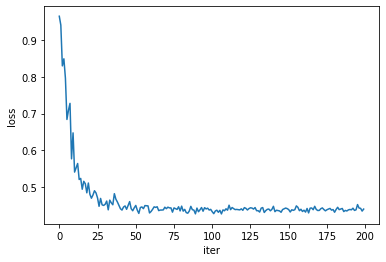

In [18]:
#hide_input
plt.plot(np.array(history.history['loss']))
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

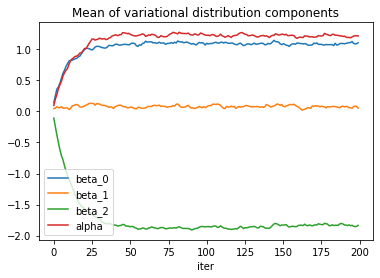

In [19]:
#hide_input
params_history = np.array(params_history)

plt.plot(params_history[:,0,:])
plt.xlabel('iter')
plt.legend(['beta_0', 'beta_1', 'beta_2', 'alpha'])
plt.title('Mean of variational distribution components')
plt.show()

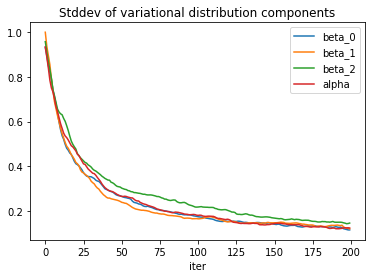

In [20]:
#hide_input
plt.plot(params_history[:,1,:])
plt.xlabel('iter')
plt.legend(['beta_0', 'beta_1', 'beta_2', 'alpha'])
plt.title('Stddev of variational distribution components')
plt.show()

In [21]:
bnn_mean, bnn_std = get_model_stats(probabilistic_model)

Convergence of the standard deviation parameters is a bit slow but could be improved with a more informed choice of starting values.

## Conclusion
The means and standard deviations of the posterior distributions inferred with `tfp.mcmc`, `tfp.vi` and `tfp.layers` (bnn) are summarized in the following table.

In [22]:
#hide_input
df_inference = pd.DataFrame({'parameter': [f'beta_{i}' for i in range(true_params.shape[0])] + ['alpha'],
                   'true_value': np.concatenate([true_params, np.reshape(true_offset, [1])], axis=0),
                   'mcmc_mean': mcmc_mean,
                   'mcmc_std': mcmc_std,
                   'vi_mean': vi_mean,
                   'vi_std': vi_std,
                   'bnn_mean': bnn_mean,
                   'bnn_std': bnn_std
                  }).set_index('parameter')

pd.options.display.float_format = '{:,.3f}'.format
df_inference

,true_value,mcmc_mean,mcmc_std,vi_mean,vi_std,bnn_mean,bnn_std
parameter,,,,,,,
beta_0,1.000,1.095,0.145,1.094,0.125,1.108,0.115
beta_1,0.000,0.079,0.122,0.084,0.115,0.055,0.120
beta_2,-2.000,-1.840,0.184,-1.838,0.163,-1.835,0.146
alpha,1.000,1.223,0.142,1.203,0.131,1.218,0.124


The results are very similar across the three methods. Convergence is quite faster with variational inference, but it requires a bit more work to specify sensible variational families.

While `tfp.vi` is applicable to a wider class of problems, `tfp.layers` gives access to Keras functionalities such as callbacks, and, more interestingly, batch training with the `tf.data.Dataset` API.

There is no definitive rule for which method to apply to which problem, but it is important to be aware of the limitations and benefits of variational inference algorithms before using them. In this example we knew the true parameters in advance, but in real applications, one should have validation procedures in place to ensure the variational family is large enough to capture the phenomenon of interest, for instance by comparison with MCMC results, or for prediction tasks with a test sets where the labels/outcomes are known.